In [1]:
#!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

In [2]:
#!wget https://universe.roboflow.com/ds/J2gwc4lbUt?key=EDrj9yWOXp -O indoor_object_detection.zip

In [3]:
#!unzip "indoor_object_detection.zip" -d "dataset2/"

## Setup

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

from datetime import datetime

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization


2024-02-06 17:51:29.422699: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 17:51:30.316140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 17:51:30.316210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 17:51:30.492217: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 17:51:30.841885: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


## Hyperparameters

In [5]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.001
EPOCH = 50
GLOBAL_CLIPNORM = 10.0

In [6]:
class_ids = [
    #"TV", "bed", "chair", "clock", "console", "consoleeeeee", "door", "fan", "light", "sofa", "switchboard", "table"
    "emptychair", "fullchair"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "../dataset2/train/"
path_annot = "../dataset2/train/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [7]:

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/4780 [00:00<?, ?it/s]

In [8]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

2024-02-06 17:54:09.531110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 17:54:09.869970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 17:54:09.870026: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 17:54:09.890195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-06 17:54:09.890290: I external/local_xla/xla/stream_executor

In [9]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [10]:
print(len(image_paths))
print(num_val)
print(train_data.__len__())

4780
956
tf.Tensor(3824, shape=(), dtype=int64)


In [11]:

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


In [12]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

## Creating Training Dataset

In [13]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

In [14]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

In [16]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",  # We will use yolov8 small backbone with coco weights
    trainable = False
)

/home/andrea/.local/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/andrea/.local/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [17]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1
)
yolo.summary()

Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    5089760   ['input_2[0][0]']             
                             128),                                                                
                              'P4': (None, None, None,                                            
                             256),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                  

In [18]:
#for layer in yolo.layers:
#    if "yolo_v8_head" in layer.name:
#        #print(layer.name + " - " + str(layer.trainable))
#        layer.trainable = True
#    else:
#        layer.trainable = False
#        
#yolo.summary()

## Compile the Model

In [19]:
#yolo.load_weights("model-s-onlyhead-test2.h5")
#yolo = keras_cv.models.load("model.h5")

In [20]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)
#yolo.summary()

In [21]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        #self.best_map = -1.0
        self.best_map = 999

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        #for batch in self.data:
        #    images, y_true = batch[0], batch[1]
        #    y_pred = self.model.predict(images, verbose=0)
        #    self.metrics.update_state(y_true, y_pred)

        #metrics = self.metrics.result(force=False)
        #logs.update(metrics)

        #print(metrics)
        #current_map = metrics["MaP"]
        current_map = logs["val_loss"]
        if current_map < self.best_map:
            self.best_map = current_map
            now = datetime.now()
            #self.model.save(self.save_path + "-test2"+ now.strftime("-%m%d%Y-%H%M%S") + ".h5")
            self.model.save(self.save_path + "-test2.h5")

        return logs


In [22]:
#yolo.save("model_3ep.h5")

## Train the Model

In [23]:
# definizione di due callback per migliorare l'addestramento
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model-s-onlyhead"), early_stopping, reduce_lr]
)

Epoch 1/50


2024-02-06 17:59:26.525972: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-06 17:59:27.194581: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-06 17:59:30.252137: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-06 17:59:45.205899: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-06 17:59:45.287117: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance 

1912/1912 [==============================] - ETA: 0s - loss: 10.7402 - box_loss: 1.9373 - class_loss: 8.8029

2024-02-06 18:06:33.843070: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


/home/andrea/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1912/1912 [==============================] - 491s 221ms/step - loss: 10.7402 - box_loss: 1.9373 - class_loss: 8.8029 - val_loss: 4.8350 - val_box_loss: 2.7123 - val_class_loss: 2.1227 - lr: 0.0010
Epoch 2/50
1912/1912 [==============================] - ETA: 0s - loss: 2.8654 - box_loss: 1.8566 - class_loss: 1.0089

2024-02-06 18:13:36.087132: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 416s 217ms/step - loss: 2.8654 - box_loss: 1.8566 - class_loss: 1.0089 - val_loss: 4.1260 - val_box_loss: 2.3302 - val_class_loss: 1.7958 - lr: 0.0010
Epoch 3/50


2024-02-06 18:14:05.888502: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 2.8156 - box_loss: 1.8018 - class_loss: 1.0138

2024-02-06 18:20:29.043668: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 411s 215ms/step - loss: 2.8156 - box_loss: 1.8018 - class_loss: 1.0138 - val_loss: 4.1739 - val_box_loss: 2.1304 - val_class_loss: 2.0436 - lr: 0.0010
Epoch 4/50


2024-02-06 18:20:57.526960: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 2.7005 - box_loss: 1.7470 - class_loss: 0.9535

2024-02-06 18:27:21.950288: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 412s 215ms/step - loss: 2.7005 - box_loss: 1.7470 - class_loss: 0.9535 - val_loss: 4.2433 - val_box_loss: 2.0996 - val_class_loss: 2.1437 - lr: 0.0010
Epoch 5/50
1912/1912 [==============================] - 417s 218ms/step - loss: 2.6709 - box_loss: 1.7161 - class_loss: 0.9549 - val_loss: 4.2067 - val_box_loss: 2.0522 - val_class_loss: 2.1546 - lr: 0.0010
Epoch 6/50
1912/1912 [==============================] - ETA: 0s - loss: 2.6141 - box_loss: 1.6858 - class_loss: 0.9283

2024-02-06 18:41:17.104480: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 418s 219ms/step - loss: 2.6141 - box_loss: 1.6858 - class_loss: 0.9283 - val_loss: 3.7478 - val_box_loss: 1.8149 - val_class_loss: 1.9329 - lr: 0.0010
Epoch 7/50


2024-02-06 18:41:46.997316: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 409s 214ms/step - loss: 2.5222 - box_loss: 1.6422 - class_loss: 0.8800 - val_loss: 4.0699 - val_box_loss: 1.9163 - val_class_loss: 2.1535 - lr: 0.0010
Epoch 8/50
1912/1912 [==============================] - 405s 212ms/step - loss: 2.4401 - box_loss: 1.5965 - class_loss: 0.8436 - val_loss: 3.7797 - val_box_loss: 1.8096 - val_class_loss: 1.9701 - lr: 0.0010
Epoch 9/50


2024-02-06 18:55:22.336539: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 405s 211ms/step - loss: 2.3933 - box_loss: 1.5827 - class_loss: 0.8106 - val_loss: 3.8248 - val_box_loss: 1.8275 - val_class_loss: 1.9973 - lr: 0.0010
Epoch 10/50


2024-02-06 19:02:07.386297: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 2.3165 - box_loss: 1.5408 - class_loss: 0.7757

2024-02-06 19:08:24.106779: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 407s 212ms/step - loss: 2.3165 - box_loss: 1.5408 - class_loss: 0.7757 - val_loss: 3.6432 - val_box_loss: 1.8059 - val_class_loss: 1.8373 - lr: 0.0010
Epoch 11/50


2024-02-06 19:08:54.518749: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 402s 210ms/step - loss: 2.2617 - box_loss: 1.5020 - class_loss: 0.7597 - val_loss: 3.7609 - val_box_loss: 1.9527 - val_class_loss: 1.8082 - lr: 0.0010
Epoch 12/50
1912/1912 [==============================] - 403s 211ms/step - loss: 2.2172 - box_loss: 1.4826 - class_loss: 0.7347 - val_loss: 3.7639 - val_box_loss: 1.8228 - val_class_loss: 1.9411 - lr: 0.0010
Epoch 13/50
1912/1912 [==============================] - 405s 212ms/step - loss: 2.1868 - box_loss: 1.4655 - class_loss: 0.7213 - val_loss: 3.5349 - val_box_loss: 1.8453 - val_class_loss: 1.6895 - lr: 0.0010
Epoch 14/50
1912/1912 [==============================] - 403s 210ms/step - loss: 2.1448 - box_loss: 1.4395 - class_loss: 0.7053 - val_loss: 3.6205 - val_box_loss: 1.7703 - val_class_loss: 1.8502 - lr: 0.0010
Epoch 15/50
   1/1912 [..............................] - ETA: 16:20 - loss: 2.5772 - box_loss: 0.2567 - class_loss: 2.3205

2024-02-06 19:35:48.529425: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 402s 210ms/step - loss: 2.1167 - box_loss: 1.4238 - class_loss: 0.6929 - val_loss: 3.4377 - val_box_loss: 1.7342 - val_class_loss: 1.7035 - lr: 0.0010
Epoch 16/50


2024-02-06 19:42:31.016192: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 400s 209ms/step - loss: 2.0708 - box_loss: 1.4073 - class_loss: 0.6635 - val_loss: 3.8385 - val_box_loss: 1.9101 - val_class_loss: 1.9284 - lr: 0.0010
Epoch 17/50
1912/1912 [==============================] - ETA: 0s - loss: 2.0394 - box_loss: 1.3948 - class_loss: 0.6445

2024-02-06 19:56:03.787408: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 397s 207ms/step - loss: 2.0394 - box_loss: 1.3948 - class_loss: 0.6445 - val_loss: 3.6379 - val_box_loss: 1.7949 - val_class_loss: 1.8429 - lr: 0.0010
Epoch 18/50
1912/1912 [==============================] - 400s 209ms/step - loss: 2.0177 - box_loss: 1.3878 - class_loss: 0.6299 - val_loss: 3.6278 - val_box_loss: 1.8568 - val_class_loss: 1.7710 - lr: 0.0010
Epoch 19/50


2024-02-06 20:03:11.388720: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 2.0128 - box_loss: 1.3896 - class_loss: 0.6232

2024-02-06 20:09:23.982936: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 400s 209ms/step - loss: 2.0128 - box_loss: 1.3896 - class_loss: 0.6232 - val_loss: 3.4924 - val_box_loss: 1.7070 - val_class_loss: 1.7854 - lr: 0.0010
Epoch 20/50
   1/1912 [..............................] - ETA: 16:12 - loss: 1.9411 - box_loss: 0.3714 - class_loss: 1.5696

2024-02-06 20:09:51.498960: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 401s 210ms/step - loss: 1.9654 - box_loss: 1.3497 - class_loss: 0.6158 - val_loss: 3.4712 - val_box_loss: 1.7217 - val_class_loss: 1.7495 - lr: 0.0010
Epoch 21/50
1912/1912 [==============================] - 402s 210ms/step - loss: 2.2265 - box_loss: 1.3912 - class_loss: 0.8353 - val_loss: 2.8350 - val_box_loss: 1.6797 - val_class_loss: 1.1554 - lr: 1.0000e-04
Epoch 22/50


2024-02-06 20:23:15.552635: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 404s 211ms/step - loss: 2.0447 - box_loss: 1.3424 - class_loss: 0.7023 - val_loss: 2.7974 - val_box_loss: 1.6070 - val_class_loss: 1.1904 - lr: 1.0000e-04
Epoch 23/50
1912/1912 [==============================] - 402s 210ms/step - loss: 2.0093 - box_loss: 1.3436 - class_loss: 0.6657 - val_loss: 2.8606 - val_box_loss: 1.6080 - val_class_loss: 1.2526 - lr: 1.0000e-04
Epoch 24/50


2024-02-06 20:36:41.988413: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 401s 209ms/step - loss: 1.9592 - box_loss: 1.3210 - class_loss: 0.6382 - val_loss: 2.9024 - val_box_loss: 1.6174 - val_class_loss: 1.2850 - lr: 1.0000e-04
Epoch 25/50
1912/1912 [==============================] - 401s 210ms/step - loss: 1.9270 - box_loss: 1.3129 - class_loss: 0.6141 - val_loss: 2.9305 - val_box_loss: 1.6122 - val_class_loss: 1.3183 - lr: 1.0000e-04
Epoch 26/50
1912/1912 [==============================] - 400s 209ms/step - loss: 1.8966 - box_loss: 1.2974 - class_loss: 0.5992 - val_loss: 2.9218 - val_box_loss: 1.5942 - val_class_loss: 1.3276 - lr: 1.0000e-04
Epoch 27/50
1912/1912 [==============================] - 396s 207ms/step - loss: 1.8886 - box_loss: 1.2956 - class_loss: 0.5930 - val_loss: 2.9365 - val_box_loss: 1.5858 - val_class_loss: 1.3508 - lr: 1.0000e-04
Epoch 28/50
1912/1912 [==============================] - 401s 210ms/step - loss: 2.1106 - box_loss: 1.3211 - class_loss: 0.7895 - val_loss: 2.4694 - val_box_loss: 1

2024-02-06 21:24:09.394012: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - ETA: 0s - loss: 1.9553 - box_loss: 1.2889 - class_loss: 0.6665

2024-02-06 21:30:22.854946: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 401s 209ms/step - loss: 1.9553 - box_loss: 1.2889 - class_loss: 0.6665 - val_loss: 2.4426 - val_box_loss: 1.4998 - val_class_loss: 0.9428 - lr: 1.0000e-05
Epoch 32/50
1912/1912 [==============================] - 400s 209ms/step - loss: 1.9412 - box_loss: 1.2849 - class_loss: 0.6563 - val_loss: 2.4797 - val_box_loss: 1.5042 - val_class_loss: 0.9755 - lr: 1.0000e-05
Epoch 33/50
1912/1912 [==============================] - 400s 209ms/step - loss: 1.9496 - box_loss: 1.2985 - class_loss: 0.6511 - val_loss: 2.4605 - val_box_loss: 1.4918 - val_class_loss: 0.9687 - lr: 1.0000e-05
Epoch 34/50
1912/1912 [==============================] - 399s 209ms/step - loss: 1.9265 - box_loss: 1.2879 - class_loss: 0.6387 - val_loss: 2.4988 - val_box_loss: 1.5128 - val_class_loss: 0.9860 - lr: 1.0000e-05
Epoch 35/50
1912/1912 [==============================] - 403s 210ms/step - loss: 1.9313 - box_loss: 1.2859 - class_loss: 0.6455 - val_loss: 2.4805 - val_box_loss: 1

2024-02-06 22:03:49.934180: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 403s 211ms/step - loss: 2.0014 - box_loss: 1.3000 - class_loss: 0.7014 - val_loss: 2.4447 - val_box_loss: 1.5071 - val_class_loss: 0.9376 - lr: 1.0000e-06
Epoch 37/50


2024-02-06 22:04:17.760628: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 405s 211ms/step - loss: 1.9772 - box_loss: 1.2979 - class_loss: 0.6793 - val_loss: 2.4090 - val_box_loss: 1.4806 - val_class_loss: 0.9284 - lr: 1.0000e-06
Epoch 38/50
1912/1912 [==============================] - 405s 211ms/step - loss: 1.9585 - box_loss: 1.2864 - class_loss: 0.6722 - val_loss: 2.3778 - val_box_loss: 1.4840 - val_class_loss: 0.8938 - lr: 1.0000e-06
Epoch 39/50
1912/1912 [==============================] - 403s 210ms/step - loss: 1.9412 - box_loss: 1.2743 - class_loss: 0.6669 - val_loss: 2.3374 - val_box_loss: 1.4794 - val_class_loss: 0.8580 - lr: 1.0000e-06
Epoch 40/50
1912/1912 [==============================] - 403s 211ms/step - loss: 1.9325 - box_loss: 1.2732 - class_loss: 0.6593 - val_loss: 2.3227 - val_box_loss: 1.4656 - val_class_loss: 0.8571 - lr: 1.0000e-06
Epoch 41/50
1912/1912 [==============================] - 402s 210ms/step - loss: 1.9507 - box_loss: 1.2908 - class_loss: 0.6599 - val_loss: 2.3337 - val_box_loss: 1

2024-02-06 22:58:02.651964: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 404s 211ms/step - loss: 1.9381 - box_loss: 1.2826 - class_loss: 0.6555 - val_loss: 2.3070 - val_box_loss: 1.4758 - val_class_loss: 0.8312 - lr: 1.0000e-06
Epoch 46/50


2024-02-06 23:04:47.208144: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1912/1912 [==============================] - 403s 211ms/step - loss: 1.9397 - box_loss: 1.2880 - class_loss: 0.6517 - val_loss: 2.3356 - val_box_loss: 1.4896 - val_class_loss: 0.8460 - lr: 1.0000e-06
Epoch 47/50
1912/1912 [==============================] - 403s 211ms/step - loss: 1.9437 - box_loss: 1.2913 - class_loss: 0.6523 - val_loss: 2.3269 - val_box_loss: 1.4811 - val_class_loss: 0.8459 - lr: 1.0000e-06
Epoch 48/50
1912/1912 [==============================] - 396s 207ms/step - loss: 1.9296 - box_loss: 1.2764 - class_loss: 0.6532 - val_loss: 2.3385 - val_box_loss: 1.4892 - val_class_loss: 0.8492 - lr: 1.0000e-06
Epoch 49/50
1912/1912 [==============================] - 416s 217ms/step - loss: 1.9391 - box_loss: 1.2837 - class_loss: 0.6554 - val_loss: 2.3010 - val_box_loss: 1.4757 - val_class_loss: 0.8253 - lr: 1.0000e-06
Epoch 50/50
1912/1912 [==============================] - 398s 208ms/step - loss: 1.9266 - box_loss: 1.2781 - class_loss: 0.6486 - val_loss: 2.3434 - val_box_loss: 1

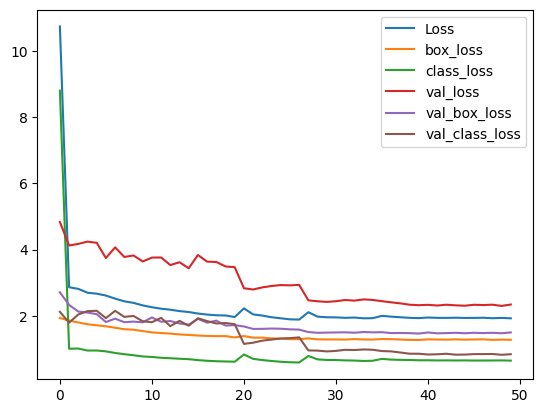

In [24]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['box_loss'], label='box_loss')
plt.plot(history.history['class_loss'], label='class_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_box_loss'], label='val_box_loss')
plt.plot(history.history['val_class_loss'], label='val_class_loss')
plt.legend(loc="upper right")
plt.show()

In [25]:
now = datetime.now()
pd.DataFrame.from_dict(history.history).to_csv('model-s-onlyhead-test2-history' + now.strftime("-%m%d%Y-%H%M%S") + '.csv',index=False)